# Indoor Scene Recognition 室内图像识别

在 kaggle GPU 平台上训练模型

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

In [11]:
# 需要从kaggle右边搜索indoor-scenes-cvpr-2019数据集
data_dir  = '/kaggle/input/indoor-scenes-cvpr-2019/indoorCVPR_09/Images'
dataset = ImageFolder(data_dir, transform = transformations)
print(f"dataset size: {len(dataset)}")

dataset size: 15620


In [13]:
from torch.utils.data.dataloader import DataLoader

batch_size = 64
train_ds, val_ds, test_ds = random_split(dataset, [13000, 2000, 620])

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

## 模型结构:

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    acc = torch.sum(preds == labels).item() / len(preds)
    return acc

class ConvClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torchvision.models.mobilenet_v2(pretrained=True)
        self.network.classifier = nn.Linear(self.network.last_channel, len(dataset.classes))  # 修改最后一层
    
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)   # cross entropy 内部已包含 softmax， 所以外部就不激活了
        return loss
    
    @torch.no_grad()
    def valid_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.item(), 'val_acc': acc}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvClassifier().to(device)
optim = torch.optim.Adam(model.parameters(), 6e-5)

## 模型训练

In [17]:
import numpy as np
history = []

num_epochs = 20

for epoch in range(num_epochs):  # Training Phase
    model.train()
    train_losses = []
    for batch in train_loader:
        loss = model.training_step(batch)
        optim.zero_grad()
        loss.backward()
        optim.step()

        train_losses.append(loss.item())

    # Validation phase
    model.eval()
    outputs = [model.valid_step(batch) for batch in val_loader]
    result = {
        'val_loss': np.mean([out['val_loss'] for out in outputs]), 
        'val_acc': np.mean([out['val_acc'] for out in outputs]), 
        'train_loss': np.mean(train_losses)
    }
    print(f"[Epoch {epoch+1}] train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
    history.append(result)

[Epoch 1] train_loss: 1.6924, val_loss: 1.4338, val_acc: 0.6388
[Epoch 2] train_loss: 1.2400, val_loss: 1.1820, val_acc: 0.6877
[Epoch 3] train_loss: 0.9930, val_loss: 1.0310, val_acc: 0.7160
[Epoch 4] train_loss: 0.8382, val_loss: 0.9419, val_acc: 0.7347
[Epoch 5] train_loss: 0.7039, val_loss: 0.8755, val_acc: 0.7537
[Epoch 6] train_loss: 0.6096, val_loss: 0.8532, val_acc: 0.7550
[Epoch 7] train_loss: 0.5321, val_loss: 0.8076, val_acc: 0.7574
[Epoch 8] train_loss: 0.4653, val_loss: 0.8042, val_acc: 0.7638
[Epoch 9] train_loss: 0.4003, val_loss: 0.7998, val_acc: 0.7617
[Epoch 10] train_loss: 0.3511, val_loss: 0.8212, val_acc: 0.7668
[Epoch 11] train_loss: 0.3095, val_loss: 0.7858, val_acc: 0.7746
[Epoch 12] train_loss: 0.2715, val_loss: 0.8069, val_acc: 0.7599
[Epoch 13] train_loss: 0.2344, val_loss: 0.8092, val_acc: 0.7658
[Epoch 14] train_loss: 0.2009, val_loss: 0.7967, val_acc: 0.7632
[Epoch 15] train_loss: 0.1815, val_loss: 0.7882, val_acc: 0.7744
[Epoch 16] train_loss: 0.1524, val

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('mobilenet_v2')

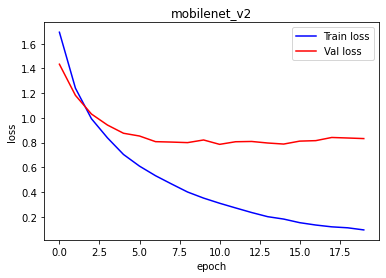

In [27]:
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-b')
plt.plot(val_losses, '-r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train loss', 'Val loss'])
plt.title('mobilenet_v2')

In [28]:
torch.save(model.state_dict(), "mobilenet_v2.pth")

In [ ]:
# 配置完成后，可以在kaggle右上角选择保存版本并运行，就可以转到后台运行，运行完成自动保存模型。